In [1]:
import numpy as np
from scipy import stats
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain, repeat
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [2]:
# https://nathanrosidi.medium.com/commonly-used-statistical-tests-in-data-science-93787568eb36

In [3]:
# Sample data: Group A and Group B
group_a = np.random.normal(50.0, 1.5, 30)
group_b = np.random.normal(60.0, 1.5, 30)

print(group_a)

[48.24776775 49.71817838 49.21945754 47.94552538 51.9297107  49.78390592
 49.55848187 49.48270776 51.74183829 50.07373537 54.20446723 49.48511241
 48.89957696 52.00649331 47.8054171  49.19255601 49.78653344 50.82059012
 49.405473   50.67035041 51.10856747 53.25979718 51.19783713 50.00853958
 47.54957764 52.31418204 50.04815109 49.88248834 49.5469804  47.94073011]


## T-Test
- A t-test is applied to ascertain whether the average difference among two groups differs significantly from each other. This emanates from the t-distribution applied in making statistical decisions.

In [4]:
# Performing an Independent T-test
t_stat, p_val = stats.ttest_ind(group_a, group_b)
print(f"T-Statistic: {t_stat}, P-Value: {p_val}")

T-Statistic: -28.49477518757835, P-Value: 8.450188170001822e-36


## Calculating Test Size

In [5]:
#Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. 
#                            This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
#Alpha value (α) — The critical value we set earlier to 0.05
#Effect size — How big of a difference we expect there to be between the conversion rates

required_n = sms.NormalIndPower().solve_power(
    sms.proportion_effectsize(0.10, 0.09), 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

13488


## P-Value of Test

In [6]:
def get_pvalue(con_conv, test_conv, con_size, test_size):
    lift = -abs(test_conv - con_conv)
    
    scale_one = con_conv * (1-con_conv) * (1/ con_size)
    scale_two = test_conv * (1-test_conv) * (1/ test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale = scale_val)  
    return p_value

get_pvalue(np.mean(group_a), np.mean(group_b), len(group_a), len(group_b))

/tmp/ipykernel_18/2511045468.py:6: RuntimeWarning: invalid value encountered in scalar power
  scale_val = (scale_one + scale_two) ** 0.5


nan

In [7]:
def create_sequence(num_ones, total_length):
    num_zeros = total_length - num_ones
    ones = repeat(1, num_ones)
    zeros = repeat(0, num_zeros)
    
    sequence = list(chain(ones, zeros))
    return sequence

In [8]:
def get_ci(lift, alpha, sd):
    val = abs(stats.norm.ppf((1-alpha)/2))
    
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    
    return (lwr_bnd, upr_bnd)

## Get Confidence Intrval

In [9]:
con_size = 50000
test_size = 50000

con_conv = 1000/con_size
test_conv = 1100/test_size

lift_mean = test_conv - con_conv
lift_variance = (1 - test_conv) * test_conv /test_size + (1 - con_conv) * con_conv / con_size
lift_sd = lift_variance**0.5
get_ci(lift_mean, 0.95, lift_sd)

(0.00022266817464121282, 0.003777331825358784)

## CI and P-value

In [10]:
n_con = 50000
n_treat = 50000

suc_con = 1000
suc_treat = 1088

successes = [suc_con, suc_treat]
nobs = [n_con, n_treat]

print(successes)
print(nobs)

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Conv Con: {suc_con/n_con:.4f}')
print(f'Conv Treat: {suc_treat/n_treat:.4f}')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.4f}, {upper_con:.4f}]')
print(f'ci 95% for treatment group: [{lower_treat:.4f}, {upper_treat:.4f}]')

[1000, 1088]
[50000, 50000]
Conv Con: 0.0200
Conv Treat: 0.0218
z statistic: -1.95
p-value: 0.052
ci 95% for control group: [0.0188, 0.0212]
ci 95% for treatment group: [0.0205, 0.0230]


## AB Test With Graph

Reject null hypothesis: There is a significant difference.
p-value 0.04907913085485977
Confidence interval for A: (0.018772826464560546, 0.021227173535439455)
Confidence interval for B: (0.020500544599091685, 0.023059455400908316)


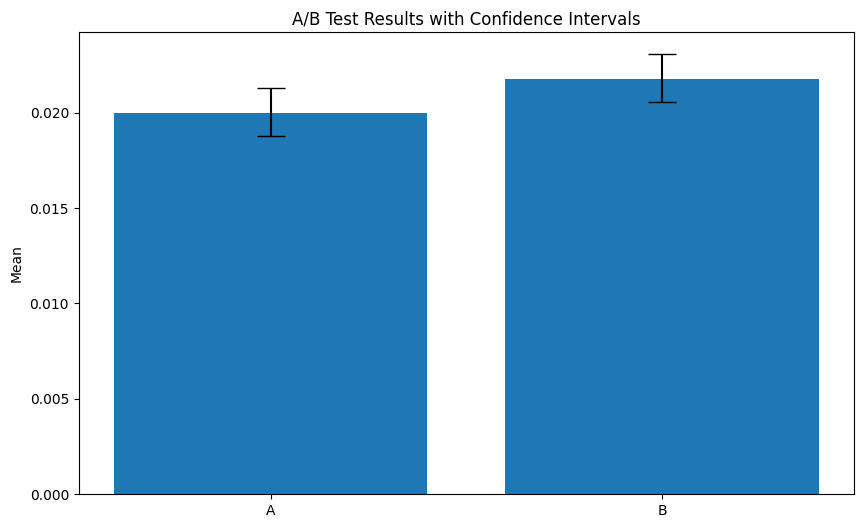

In [11]:
data_a = np.array(create_sequence(1000, 50000))  
data_b = np.array(create_sequence(1089, 50000))  

t_stat, p_value = stats.ttest_ind(data_a, data_b)
alpha = 0.05  # Significance level

if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference.")
    print("p-value",p_value)
else:
    print("Fail to reject null hypothesis: No significant difference.")
    print("p-value",p_value)
    
confidence_level = 0.95

# Calculate means and standard errors
mean_a = np.mean(data_a)
mean_b = np.mean(data_b)
std_a = np.std(data_a, ddof=1)  # Use ddof=1 for sample standard deviation
std_b = np.std(data_b, ddof=1)
n_a = len(data_a)
n_b = len(data_b)

# Calculate standard errors
se_a = std_a / np.sqrt(n_a)
se_b = std_b / np.sqrt(n_b)

# Calculate confidence intervals
ci_a = stats.t.interval(confidence_level, df=n_a - 1, loc=mean_a, scale=se_a)
ci_b = stats.t.interval(confidence_level, df=n_b - 1, loc=mean_b, scale=se_b)

print(f"Confidence interval for A: {ci_a}")
print(f"Confidence interval for B: {ci_b}")

plt.figure(figsize=(10, 6))
plt.bar(['A', 'B'], [mean_a, mean_b], yerr=[(mean_a - ci_a[0], ci_a[1] - mean_a), (mean_b - ci_b[0], ci_b[1] - mean_b)], capsize=10)
plt.ylabel('Mean')
plt.title('A/B Test Results with Confidence Intervals')
plt.show()

In [12]:
data_a

array([1, 1, 1, ..., 0, 0, 0])